# Kinematic analysis of J0227+01

Author: [Kiara Hervella](https://www.linkedin.com/in/kiara-hervella/)

## Initialisation

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('tab10',8)
sns.set_style('whitegrid')
import numpy as np

from astropy.modeling import models, fitting
from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(H0=70,Om0=0.3)
from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines
from specutils.analysis import line_flux

import astropy.units as u
from astropy.table import QTable, Table
from astropy.io import ascii

from tied_parameters import *
from aux_functions import *

In [2]:
# Function for saving the results from the code
def table_add_model(line_combo_fit,t): 
  ncomps = line_combo_fit.n_submodels
  if ncomps > 1:
    for i in range(ncomps):
      t.add_row(line_tab[i])
  else:
    t.add_row(line_tab)
  return t

In [3]:
# Import the information about the targets
targets_info = ascii.read('../spectra/targets_info_complete.csv')

# Choosing a target
tgt_name='J0227+01'
tgt_info = targets_info[targets_info['ShortName'] == tgt_name]
redshift=tgt_info['z'][0]

# Choosing the extracted spectra
specfile='../spectra/stcal_q0227-red_nuclear.fits' #spectrum to be measured
spec1d = Spectrum1D.read(specfile) #read the spectrum

wave=spec1d.spectral_axis.value*u.angstrom
norm = np.median(spec1d.flux) #normalizing the flux for a correct performance of the programm
flux =spec1d.flux/norm

In [4]:
# Output file's names
plotfile='Graphs/Parametric/'+tgt_name+'.pdf'
logfile='logfiles/'+tgt_name+'.txt'

## Kinematic analysis

### Fit of the continuum

Text(0.5, 1.0, 'J0227+01')

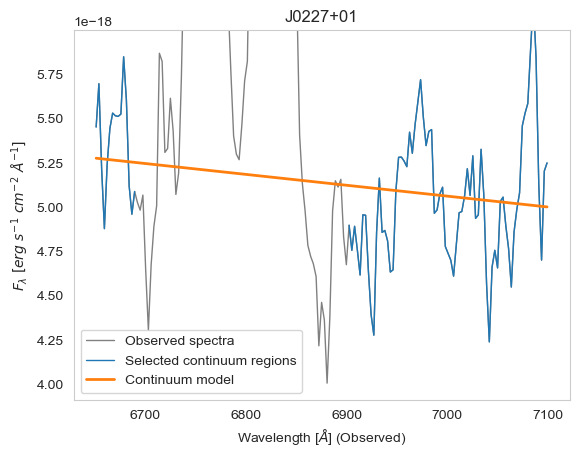

In [5]:
# Define the regions where to fit the continuum
w1c = 6650 * u.angstrom #segment on the left
w2c = 6690 * u.angstrom
w3c = 6900* u.angstrom #on the right
w4c = 7100 * u.angstrom

# Fit the continuum and estimate the noise
wlimits_cont = ([w1c,w2c],[w3c,w4c])
mask_cont = (wave > w1c) & (wave < w4c)
poly_cont,noise=fit_continuum(wave,flux,wlimits_cont)

# For plotting the chosen region of continuum
wave_cont = wave[mask_cont]
flux_cont = flux[mask_cont]
flux_cont_model = poly_cont(wave_cont)
mask_cont_blue = (wave > w1c) & (wave < w2c)   
mask_cont_red = (wave > w3c) & (wave < w4c)

sns.set_palette('tab10',8)
xlabel=r"Wavelength [$\AA$] (Observed)"
ylabel='$F_\lambda$ $[erg\ s^{-1}\ cm^{-2}\ \AA^{-1}]$'
plt.plot(wave_cont,flux_cont*norm,linewidth=1,color="gray",label="Observed spectra")
plt.plot(wave[mask_cont_blue],flux[mask_cont_blue]*norm,label='Selected continuum regions',color=sns.color_palette('tab10')[0],linewidth=1)
plt.plot(wave[mask_cont_red],flux[mask_cont_red]*norm,color=sns.color_palette('tab10')[0],linewidth=1)
plt.plot(wave_cont,flux_cont_model*norm,label='Continuum model',color=sns.color_palette('tab10')[1],linewidth=2)
plt.legend()
plt.grid()
plt.ylim(np.median(flux_cont*norm.value)-0.25*np.median(flux_cont*norm.value),np.median(flux_cont*norm.value)+0.15*np.median(flux_cont*norm.value))
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(tgt_name)

### Modeling of the [OIII] emission lines

In [6]:
# Define the line region
w1 = 4915*(1+redshift) *u.angstrom #below [OIII]4959
w2 = 5050*(1+redshift) *u.angstrom #above [OIII]5007
mask = (wave > w1) & (wave < w2) 

flux_reg = flux[mask] #Flux in the line region
wave_reg = wave[mask] #Line region
cont_reg_model = poly_cont(wave_reg)  #Continuum contribution in the line region
flux_reg_nocont=flux_reg - cont_reg_model #Flux without the continuum

# Define the initial parameters for the model
wave_O3r = 5007*(1+redshift)*u.angstrom
wave_O3b = 4959*(1+redshift)*u.angstrom
stddev_n = 5*u.angstrom
amp_O3r = flux_reg_nocont[np.argmin(abs(wave_reg-wave_O3r))] #flux of the nearest point to the central position of the line (wave_o3)

In [7]:
# Choosing the gaussian components for each emission line
c1 = models.Gaussian1D(amplitude=amp_O3r/2, mean=wave_O3r, stddev=stddev_n,name='[OIII]5007n1')
c2 = models.Gaussian1D(name='[OIII]4959n1')
c3 = models.Gaussian1D(amplitude=amp_O3r/2, mean=wave_O3r+1*u.angstrom, stddev=stddev_n,name='[OIII]5007n2')
c4 = models.Gaussian1D(name='[OIII]4959n2')
c5 = models.Gaussian1D(amplitude=amp_O3r/3, mean=wave_O3r, stddev=3*stddev_n,name='[OIII]5007i')
c6 = models.Gaussian1D(name='[OIII]4959i') 

# Relations between [OIII]5007 and [OIII]4959 lines 
c2.mean.tied = tie_center_OIIIn1 #solidarity
c2.stddev.tied = tie_stddevn_OIIIn1 #same kinematic fwhm
c2.amplitude.tied = tie_ampl_OIIIn1 #ratio between the line (amplitude)
c4.mean.tied = tie_center_OIIIn2 #solidarity
c4.stddev.tied = tie_stddevn_OIIIn2 #same kinematic fwhm
c4.amplitude.tied = tie_ampl_OIIIn2 #ratio between the line (amplitude)
c6.mean.tied = tie_center_OIIIi #solidarity 
c6.stddev.tied = tie_stddevn_OIIIi #same kinematic fwhm
c6.amplitude.tied = tie_ampl_OIIIi #ratio between the line (amplitude)

# Conditions to the gaussian amplitudes
c1.amplitude.bounds=(0,None)
c2.amplitude.bounds=(0,None)
c3.amplitude.bounds=(0,None)
c4.amplitude.bounds=(0,None)
c5.amplitude.bounds=(0,None)
c6.amplitude.bounds=(0,None)

line_combo = c1 + c2 + c3 + c4 + c5 + c6 #Gaussians to fit



Initial parameters of the parametric model [5.97797741e+00 6.82333507e+03 4.24834439e+00 1.99265914e+00
 6.75801325e+03 4.20767373e+00 7.88765510e+00 6.82382948e+03
 5.98936339e+00 2.62921837e+00 6.75850293e+03 5.93202543e+00
 1.79417404e+00 6.82651089e+03 1.14046740e+01 5.98058012e-01
 6.76115867e+03 1.12954936e+01]


Initial velocities of the non-parametric analysis [6823.60334366  740.24328272   55.89363364 -455.33860659  567.12587388
   11.10750135   44.542953  ]


 -------- 


 Executing simulation


[OIII]5007n1
5.940669660167227e-16 erg / (A cm2 s) 1.0037086848250347 1.304352651658158e-17 erg / (A cm2 s)
 Center= 6823.31 +/- 0.17
 FWHM= 4.184e+02 km / s +/- 4.550e+01 km / s
 Flux= 5.941e-16 erg / (A cm2 s) +/- 3.010e-16 Angstrom erg / (A cm2 s)
 EW= 45.38 +/- 22.99 Angstrom
 
[OIII]4959n1
1.9612659530945632e-16 erg / (A cm2 s) 1.011518200018063 1.304352651658158e-17 erg / (A cm2 s)
 Center= 6757.99 +/- 0.16
 FWHM= 4.184e+02 km / s +/- 4.550e+01 km / s
 Flux= 1.961e-16 erg / (A cm2 s) +/- 9.938e-17 Angstrom erg / (A cm2 s)
 EW= 14.87 +/- 7.53 Angstrom
 
[OIII]5007n2
1.7574881744691666e-15 erg / (A cm2 s) 1.0037086848250347 1.304352651658158e-17 erg / (A cm2 s)
 Center= 6823.76 +/- 0.16
 FWHM= 5.982e+02 km / s +/- 3.291e+01 km / s
 Flux= 1.757e-15 erg / (A cm2 s) +/- 4.072e-16 Angstrom erg / (A cm2 s)
 EW= 134.24 +/- 31.10 Angstrom
 
[OIII]4959n2
5.80221072156984e-16 erg / (A cm2 s) 1.011518200018063 1.304352651658158e-17 erg / (A cm2 s)
 Center= 6758.43 +/- 0.16
 FWHM= 5.982e+02 k

Reduced chi-squared:  85.76893230387138




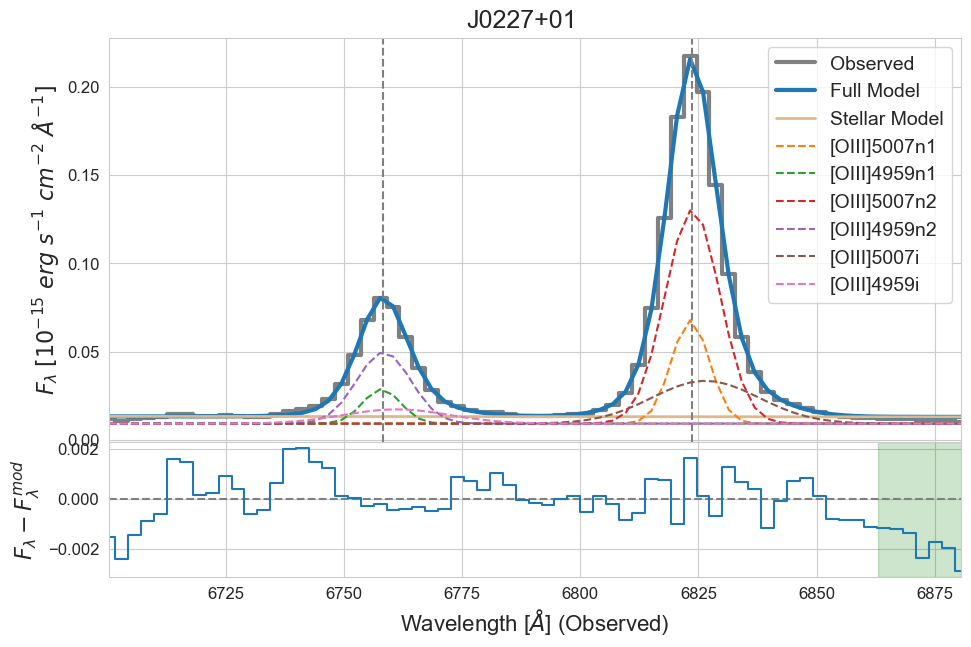

In [8]:
# Perfom the fit to the model
sns.set_palette('tab10',8)
line_combo_fit, line_combo_error, line_tab, chi2, blueshift, eblueshift, nonpar_fit, nonpar_error,\
outflow_fit, outflow_error, outflow_blue_fit, outflow_blue_error, outflow_red_fit, outflow_red_error,\
params_simul, params_simul_nonpar = perform_fit_plot(wave_reg,flux_reg,cont_reg_model,wave_O3r,wave_O3b,\
          line_combo,noise,Nsimul=1000,plotfile=plotfile,logfile=logfile,flux_norm=norm*(1+redshift)**3,tgt_name=tgt_name)
                    
print('Reduced chi-squared: ',chi2)
print('\n')

#### Simulated distributions

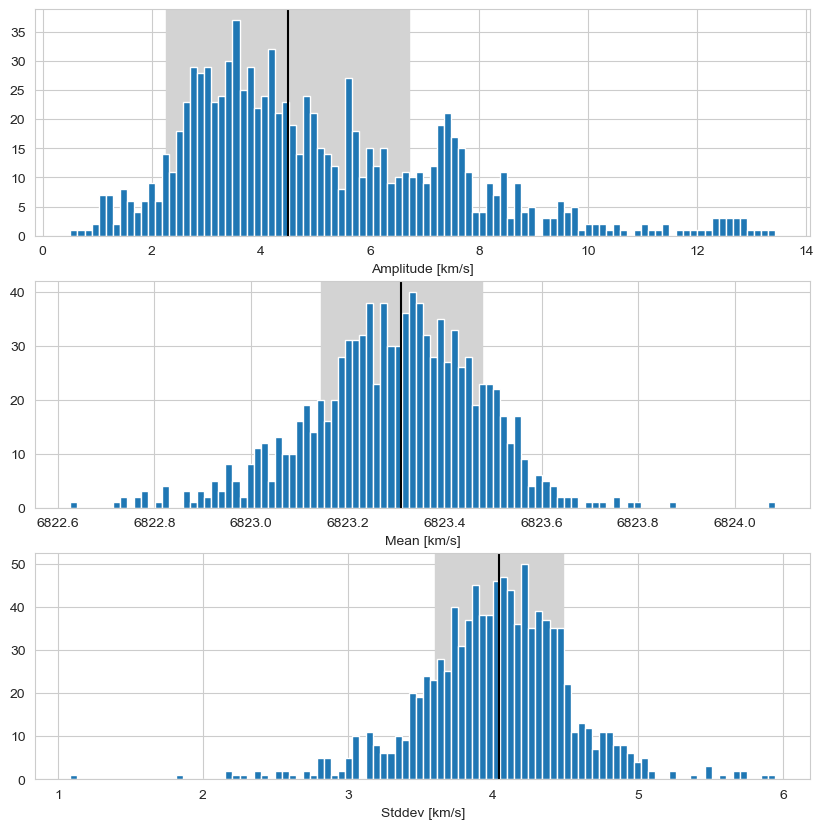

In [9]:
# Checking the simulated normal distributions for the parameters of the first modeled component
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,10))
ax1.axvspan(line_combo_fit.parameters[0]-line_combo_error.parameters[0],line_combo_fit.parameters[0]+line_combo_error.parameters[0],color='lightgrey')
ax1.hist(params_simul[0],bins=100)
ax1.axvline(line_combo_fit.parameters[0],color='black')
ax1.set_xlabel('Amplitude [km/s]')

ax2.axvspan(line_combo_fit.parameters[1]-line_combo_error.parameters[1],line_combo_fit.parameters[1]+line_combo_error.parameters[1],color='lightgrey')
ax2.hist(params_simul[1],bins=100)
ax2.axvline(line_combo_fit.parameters[1],color='black')
ax2.set_xlabel('Mean [km/s]')

ax3.axvspan(line_combo_fit.parameters[2]-line_combo_error.parameters[2],line_combo_fit.parameters[2]+line_combo_error.parameters[2],color='lightgrey')
ax3.hist(params_simul[2],bins=100)
ax3.axvline(line_combo_fit.parameters[2],color='black')
ax3.set_xlabel('Stddev [km/s]')
plt.show()


Text(0.5, 0, 'Asymmetry [km/s]')

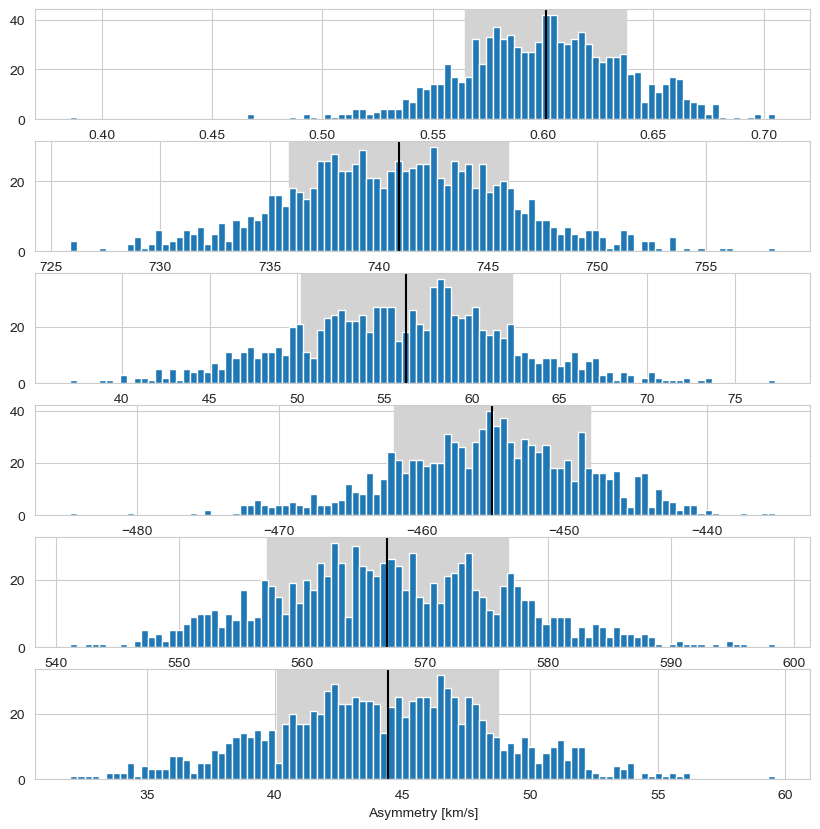

In [10]:
# Checking the simulated normal distributions for the non-parametric velocites
f,(ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,1,figsize=(10,10))
ax1.axvspan(nonpar_fit[0]-nonpar_error[0],nonpar_fit[0]+nonpar_error[0],color='lightgrey')
ax1.hist(params_simul_nonpar[0],bins=100)
ax1.axvline(nonpar_fit[0],color='black')
ax1.set_xlabel('Center [km/s]')

ax2.axvspan(nonpar_fit[1]-nonpar_error[1],nonpar_fit[1]+nonpar_error[1],color='lightgrey')
ax2.hist(params_simul_nonpar[1],bins=100)
ax2.axvline(nonpar_fit[1],color='black')
ax2.set_xlabel('W80 [km/s]')

ax3.axvspan(nonpar_fit[2]-nonpar_error[2],nonpar_fit[2]+nonpar_error[2],color='lightgrey')
ax3.hist(params_simul_nonpar[2],bins=100)
ax3.axvline(nonpar_fit[2],color='black')
ax3.set_xlabel('DeltaV [km/s]')

ax4.axvspan(nonpar_fit[3]-nonpar_error[3],nonpar_fit[3]+nonpar_error[3],color='lightgrey')
ax4.hist(params_simul_nonpar[3],bins=100)
ax4.axvline(nonpar_fit[3],color='black')
ax4.set_xlabel('V05 [km/s]')

ax5.axvspan(nonpar_fit[4]-nonpar_error[4],nonpar_fit[4]+nonpar_error[4],color='lightgrey')
ax5.hist(params_simul_nonpar[4],bins=100)
ax5.axvline(nonpar_fit[4],color='black')
ax5.set_xlabel('V95 [km/s]')

ax6.axvspan(nonpar_fit[6]-nonpar_error[6],nonpar_fit[6]+nonpar_error[6],color='lightgrey')
ax6.hist(params_simul_nonpar[6],bins=100)
ax6.axvline(nonpar_fit[6],color='black')
ax6.set_xlabel('Asymmetry [km/s]')

#### Parametric model

In [11]:
# Table with the fitting parameters for each component of each line
table = QTable(names=('LineID', 'Center', 'eCenter','Flux','eFlux','FWHM','eFWHM','EW','eEW'), \
           dtype=('U12','f4', 'f4','f4', 'f4','f4', 'f4','f4','f4'))
table_par = table_add_model(line_combo_fit,table)

# Add name
table_par.add_column(tgt_name,index=0,name='Name')

# Remove non-needed ones
table_par.remove_columns(['Center','eCenter','EW','eEW',])

# Blueshift of each component
table_par.add_column(blueshift,name='Blueshift')
table_par.add_column(eblueshift,name='eBlueshift')

# Luminosity and flux percentage
table_par.add_column(np.zeros(len(table_par['LineID'])),name='Luminosity')
table_par.add_column(np.zeros(len(table_par['LineID'])),name='eLuminosity')
table_par.add_column(np.zeros(len(table_par['LineID'])),name='Percentage')
table_par.add_column(np.zeros(len(table_par['LineID'])),name='ePercentage')

Flux_4959=[]
Flux_5007=[]
for i in range(len(table_par['LineID'])):
    if table_par['LineID'][i][:10]=='[OIII]5007':
        Flux_5007.append(table_par['Flux'][i])

    if table_par['LineID'][i][:10]=='[OIII]4959':
        Flux_4959.append(table_par['Flux'][i])

for i in range(len(table_par['LineID'])):
    table_par['Luminosity'][i]=table_par['Flux'][i]*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2
    table_par['eLuminosity'][i]=table_par['eFlux'][i]*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2

    if table_par['LineID'][i][:10]=='[OIII]5007':				
        table_par['Percentage'][i]=table_par['Flux'][i]/np.sum(Flux_5007)
        table_par['ePercentage'][i]=table_par['eFlux'][i]/np.sum(Flux_5007)

    if table_par['LineID'][i][:10]=='[OIII]4959':				
        table_par['Percentage'][i]=table_par['Flux'][i]/np.sum(Flux_4959)
        table_par['ePercentage'][i]=table_par['eFlux'][i]/np.sum(Flux_4959)

In [12]:
table_par

Name,LineID,Flux,eFlux,FWHM,eFWHM,Blueshift,eBlueshift,Luminosity,eLuminosity,Percentage,ePercentage
str8,str12,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64
J0227+01,[OIII]5007n1,5.94067e-16,3.0103477e-16,418.3945,45.497166,-13.255319061089367,7.297674136250008,2.6693403939788826e+41,1.35264926787284e+41,0.19549746811389923,0.09906549006700516
J0227+01,[OIII]4959n1,1.961266e-16,9.9384295e-17,418.3945,45.497166,-13.25531906112266,7.297674136266397,8.812620047348924e+40,4.465666683774695e+40,0.19549746811389923,0.09906549006700516
J0227+01,[OIII]5007n2,1.7574881e-15,4.072007e-16,598.18365,32.905262,6.406343352550081,7.089653643501168,7.896978261172166e+41,1.829688025557313e+41,0.578359842300415,0.1340029090642929
J0227+01,[OIII]4959n2,5.8022106e-16,1.3443413e-16,598.18365,32.905262,6.406343352550081,7.08965364350117,2.6071260816163384e+41,6.040572468513996e+40,0.578359842300415,0.1340028941631317
J0227+01,[OIII]5007i,6.8719e-16,1.3050028e-16,1168.9415,53.614136,126.71147695121994,23.13530107887298,3.0877730467668062e+41,5.863811098248718e+40,0.22614268958568573,0.04294544830918312
J0227+01,[OIII]4959i,2.2687044e-16,4.3083653e-17,1168.9415,53.614136,126.71147695121994,23.13530107888949,1.0194043036248757e+41,1.9358917058161147e+40,0.22614268958568573,0.04294544830918312


In [13]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/parametric.txt').to_pandas()
parametric = file.drop(file[file['Name']==tgt_name].index).append(table_par.to_pandas())
ascii.write(QTable.from_pandas(parametric.sort_values('Name')), 'Tables/parametric.txt', format='csv', overwrite = True, formats={'Flux':'%8.2e','eFlux':'%8.2e','FWHM': '%8.1f','eFWHM':'%8.1f','Blueshift': '%8.2f','eBlueshift':'%8.2f','Luminosity': '%8.2e','eLuminosity':'%8.2e','Percentage': '%8.3f','ePercentage':'%8.3f'})

C:\Users\HP\AppData\Local\Temp\ipykernel_10756\2174204615.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parametric = file.drop(file[file['Name']==tgt_name].index).append(table_par.to_pandas())


In [14]:
table_5007 = QTable(names=('Name','LineID','Flux','eFlux','FWHM','eFWHM','Blueshift','eBlueshift','Luminosity','eLuminosity','Percentage','ePercentage'), \
           dtype=('U12','U12','f4', 'f4','f4', 'f4','f4', 'f4','f8','f8','f4', 'f4'))
for i in range(len(table_par['LineID'])):
    if table_par['LineID'][i][:10]=='[OIII]5007':
        table_5007.add_row(table_par[i])

# Save the results in a latex format for the 5007 line
texfile = ascii.read('Tables/parametric.tex',format='latex').to_pandas()
texparametric = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_5007.to_pandas())
ascii.write(QTable.from_pandas(texparametric.sort_values('Name')), 'Tables/parametric.tex', format='latex', overwrite = True, formats={'Flux':'%8.2e','eFlux':'%8.2e','FWHM': '%8.1f','eFWHM':'%8.1f','Blueshift': '%8.2f','eBlueshift':'%8.2f','Luminosity': '%8.3e','eLuminosity':'%8.3e','Percentage': '%8.3f','ePercentage':'%8.3f'})

C:\Users\HP\AppData\Local\Temp\ipykernel_10756\1745872242.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  texparametric = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_5007.to_pandas())


#### Non-parametric analysis

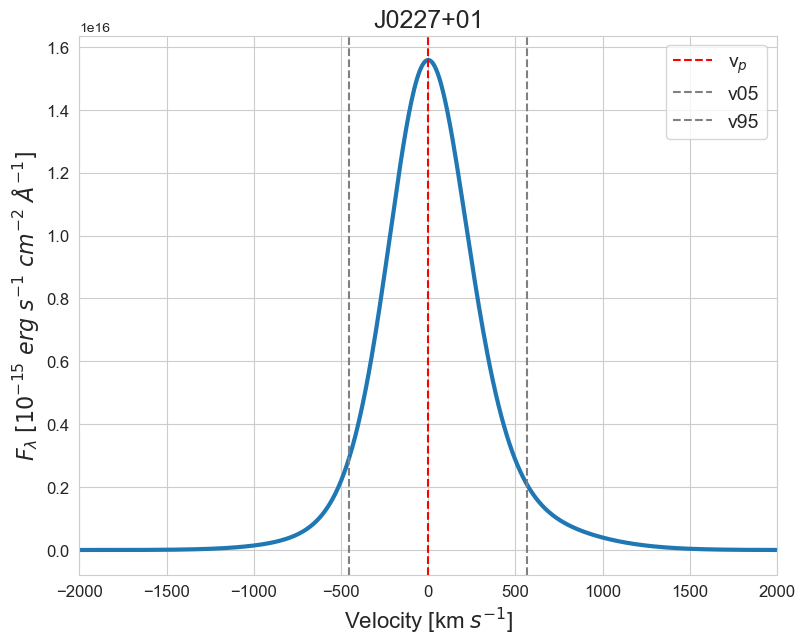

In [15]:
perform_nonpar_plot(tgt_name,wave_reg,line_combo_fit,nonpar_fit,flux_norm=norm*(1+redshift)**3)

In [16]:
table_nonpar = QTable(names=('Name', 'Wavepeak', 'Width80','DeltaV','V05','V95','Vmed','Asymmetry'),\
           dtype=('U12','f4', 'f4','f4','f4','f4','f4','f4'))
table_nonpar.add_row(np.append(tgt_name,nonpar_fit))
table_nonpar.add_columns(np.array(nonpar_error,dtype='f4'),indexes=[2,3,4,5,6,7,8],names=('eWavepeak', 'eWidth80','eDeltaV','eV05','eV95','eVmed','eAsymmetry'))

In [17]:
table_nonpar

Name,Wavepeak,eWavepeak,Width80,eWidth80,DeltaV,eDeltaV,V05,eV05,V95,eV95,Vmed,eVmed,Asymmetry,eAsymmetry
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0227+01,6823.601,0.036460448,740.9085,4.997878,56.223286,6.026416,-455.0715,6.8693466,566.9312,9.787784,11.366515,1.7442577,44.41433,4.3187203


In [18]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/nonparametric.txt').to_pandas()
nonparametric = file.drop(file[file['Name']==tgt_name].index).append(table_nonpar.to_pandas())
ascii.write(QTable.from_pandas(nonparametric.sort_values('Name')), 'Tables/nonparametric.txt', format='csv', overwrite=True, \
            formats={'Name':'','Wavepeak': '%8.2f','eWavepeak': '%8.2f','Width80': '%8.2f','eWidth80': '%8.2f','DeltaV': '%8.2f','eDeltaV': '%8.2f','V05': '%8.2f','eV05': '%8.2f','V95': '%8.2f','eV95': '%8.2f','Vmed': '%8.2f','eVmed': '%8.2f','Asymmetry': '%8.2f','eAsymmetry': '%8.2f'})


C:\Users\HP\AppData\Local\Temp\ipykernel_10756\2927441754.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nonparametric = file.drop(file[file['Name']==tgt_name].index).append(table_nonpar.to_pandas())


In [19]:
# Save the results in a latex format for the 5007 line
file = ascii.read('Tables/nonparametric.tex').to_pandas()
texnonparametric = file.drop(file[file['Name']==tgt_name].index).append(table_nonpar.to_pandas())
ascii.write(QTable.from_pandas(texnonparametric.sort_values('Name')), 'Tables/nonparametric.tex', format='latex', overwrite=True, \
            formats={'Name':'','Wavepeak': '%8.2f','eWavepeak': '%8.2f','Width80': '%8.2f','eWidth80': '%8.2f','DeltaV': '%8.2f','eDeltaV': '%8.2f','V05': '%8.2f','eV05': '%8.2f','V95': '%8.2f','eV95': '%8.2f','Vmed': '%8.2f','eVmed': '%8.2f','Asymmetry': '%8.2f','eAsymmetry': '%8.2f'})


C:\Users\HP\AppData\Local\Temp\ipykernel_10756\217271521.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  texnonparametric = file.drop(file[file['Name']==tgt_name].index).append(table_nonpar.to_pandas())


# Outflow mass, outflow mass rate and energy rate

## Giovanna's method: outflow line flux

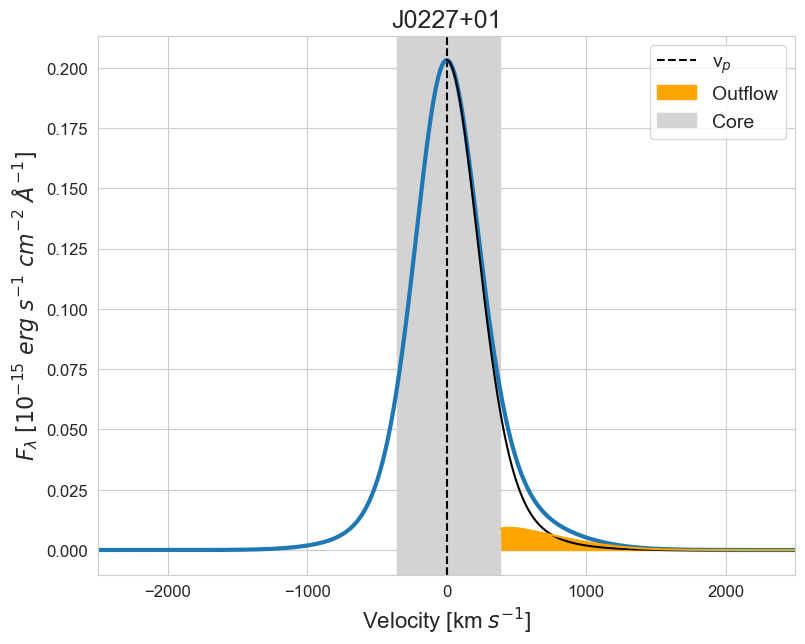

In [20]:
perform_outflow_plot(tgt_name,wave_reg,line_combo_fit,flux_norm=norm*(1+redshift)**3)

In [21]:
table_outflow = QTable(names=('Name','Foutflow', 'Voutflow'),\
           dtype=('U12','f8', 'f8'))
table_outflow.add_row(np.append(tgt_name,outflow_fit))
table_outflow.add_columns(np.array(outflow_error,dtype='f8'),indexes=[2,3],names=('eFoutflow', 'eVoutflow'))
table_outflow.add_column((table_outflow['Foutflow']*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2).value,name='Loutflow')
table_outflow.add_column((table_outflow['eFoutflow']*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2).value,name='eLoutflow')

In [22]:
table_outflow

Name,Foutflow,eFoutflow,Voutflow,eVoutflow,Loutflow,eLoutflow
str12,float64,float64,float64,float64,float64,float64
J0227+01,1.1394560558306116e-16,9.738856180442623e-18,673.3056443558518,20.209563321393397,5.11995477597051e+40,4.375991768914654e+39


In [23]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/outflow_giovanna.txt').to_pandas()
outflow_giovanna = file.drop(file[file['Name']==tgt_name].index).append(table_outflow.to_pandas())
ascii.write(QTable.from_pandas(outflow_giovanna.sort_values('Name')), 'Tables/outflow_giovanna.txt', format='csv', overwrite = True,\
            formats={'Foutflow':'%8.2e','eFoutflow':'%8.2e','Voutflow':'%8.2e','eVoutflow':'%8.2e','Loutflow':'%8.2e','eLoutflow':'%8.2e'})

# Open existing file and overwrite the data for this target
texfile = ascii.read('Tables/outflow_giovanna.tex').to_pandas()
tex_outflow_giovanna = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow.to_pandas())
ascii.write(QTable.from_pandas(tex_outflow_giovanna.sort_values('Name')), 'Tables/outflow_giovanna.tex', format='latex', overwrite = True,\
            formats={'Foutflow':'%8.2e','eFoutflow':'%8.2e','Voutflow':'%8.2e','eVoutflow':'%8.2e','Loutflow':'%8.2e','eLoutflow':'%8.2e'})

C:\Users\HP\AppData\Local\Temp\ipykernel_10756\1200331943.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflow_giovanna = file.drop(file[file['Name']==tgt_name].index).append(table_outflow.to_pandas())
C:\Users\HP\AppData\Local\Temp\ipykernel_10756\1200331943.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tex_outflow_giovanna = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow.to_pandas())


#### Outflow energetics

In [24]:
outflow_energy,outflow_energy_errors = outflow_energetics_uncertainties(table_outflow,Nsimul=200)

In [25]:
table_outflow_energy = QTable(names=('Name','LogMof','LogEkin','Rout','LogE.kin','M.of'),\
           dtype=('U12','f4','f4','f4','f4','f4'),\
           descriptions=('',r'[M$_\odot$]','[erg]','[erg $\cdot$ s$^{-1}$]','[kpc]','[M$_\odot$ $\cdot$ yr$^{-1}$]'))
table_outflow_energy.add_row(np.append(tgt_name,outflow_energy))
table_outflow_energy.add_columns(np.array(outflow_energy_errors,dtype='f4'),indexes=[2,3,4,5,6],names=('eLogMof','eLogEkin','eRout','eLogE.kin','eM.of'))

In [26]:
table_outflow_energy

Name,LogMof,eLogMof,LogEkin,eLogEkin,Rout,eRout,LogE.kin,eLogE.kin,M.of,eM.of
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0227+01,4.9971437,0.036591828,53.652,0.04604255,1.0,0.0,35.47175,0.05584562,0.2046738,0.018469159


In [27]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/outflow_energy_giovanna.txt').to_pandas()
outflow_energy_giovanna = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy.to_pandas())
ascii.write(QTable.from_pandas(outflow_energy_giovanna.sort_values('Name')), 'Tables/outflow_energy_giovanna.txt', format='csv', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

# Open existing file and overwrite the data for this target
texfile = ascii.read('Tables/outflow_energy_giovanna.tex').to_pandas()
tex_outflow_energy_giovanna = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy.to_pandas())
ascii.write(QTable.from_pandas(tex_outflow_energy_giovanna.sort_values('Name')), 'Tables/outflow_energy_giovanna.tex', format='latex', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

C:\Users\HP\AppData\Local\Temp\ipykernel_10756\2348874735.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflow_energy_giovanna = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy.to_pandas())
C:\Users\HP\AppData\Local\Temp\ipykernel_10756\2348874735.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tex_outflow_energy_giovanna = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy.to_pandas())


## Non parametric method: v05 and v95

### V05 and v95

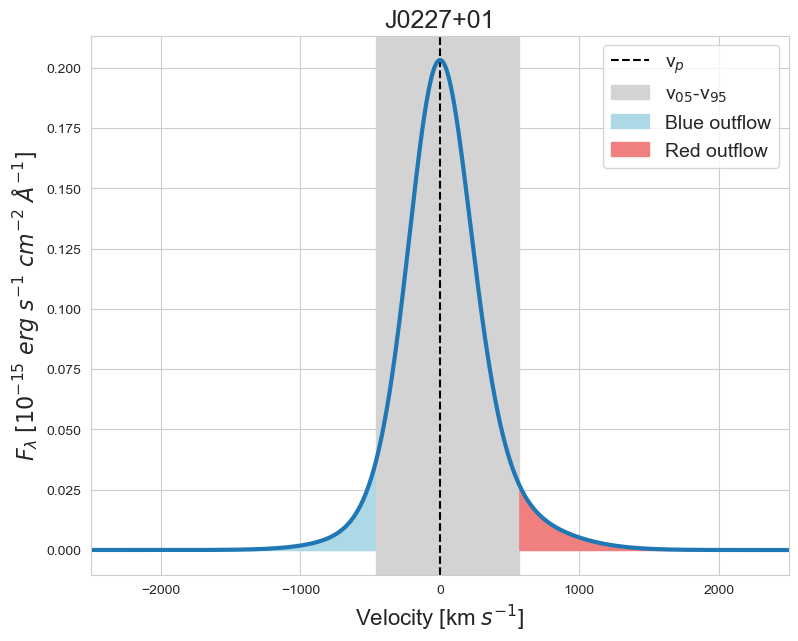

In [28]:
perform_outflow_nonpar_plot(tgt_name,wave_reg,line_combo_fit,nonpar_fit,flux_norm=norm*(1+redshift)**3)

In [29]:
table_outflow_nonpar = QTable(names=('Name','Foutflow', 'Voutflow'),\
           dtype=('U12','f8', 'f8'))
table_outflow_nonpar.add_row(np.append(tgt_name,outflow_blue_fit))
table_outflow_nonpar.add_row(np.append(tgt_name,outflow_red_fit))

table_outflow_nonpar.add_column(np.array(['Blue','Red' ]),index=1,name=('Outflow'))

table_outflow_nonpar.add_columns(np.array(np.array((outflow_blue_error,outflow_red_error)).T,dtype='f8'),indexes=[2,3],names=('eFoutflow', 'eVoutflow'))
table_outflow_nonpar.add_column(table_outflow_nonpar['Foutflow']*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2,name='Loutflow')
table_outflow_nonpar.add_column(table_outflow_nonpar['eFoutflow']*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2,name='eLoutflow')

In [30]:
table_outflow_nonpar

Name,Outflow,eFoutflow,Foutflow,eVoutflow,Voutflow,Loutflow,eLoutflow
,,,,,,,
str12,str4,float64,float64,float64,float64,float64,float64
J0227+01,Blue,2.8187801969962755e-18,1.405207874459702e-16,13.55752733671731,-584.839092793771,6.314066024096721e+40,1.266571629346591e+39
J0227+01,Red,2.1241489237228432e-18,1.5434780284059817e-16,18.57678397333123,735.1902004854433,6.935359782156903e+40,9.544507110420869e+38


In [31]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/outflow_nonpar.txt').to_pandas()
outflow_nonpar = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_nonpar.to_pandas())
ascii.write(QTable.from_pandas(outflow_nonpar.sort_values('Name')), 'Tables/outflow_nonpar.txt', format='csv', overwrite = True,\
            formats={'Foutflow':'%8.2e','eFoutflow':'%8.2e','Voutflow':'%8.2e','eVoutflow':'%8.2e','Loutflow':'%8.2e','eLoutflow':'%8.2e'})

# Open existing file and overwrite the data for this target
texfile = ascii.read('Tables/outflow_nonpar.tex').to_pandas()
tex_outflow_nonpar = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_nonpar.to_pandas())
ascii.write(QTable.from_pandas(outflow_nonpar.sort_values('Name')), 'Tables/outflow_nonpar.tex', format='latex', overwrite = True,\
            formats={'Foutflow':'%8.2e','eFoutflow':'%8.2e','Voutflow':'%8.2e','eVoutflow':'%8.2e','Loutflow':'%8.2e','eLoutflow':'%8.2e'})

C:\Users\HP\AppData\Local\Temp\ipykernel_10756\3637349706.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflow_nonpar = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_nonpar.to_pandas())
C:\Users\HP\AppData\Local\Temp\ipykernel_10756\3637349706.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tex_outflow_nonpar = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_nonpar.to_pandas())


#### Outflow energetics

In [32]:
outflow_energy_nonpar,outflow_energy_nonpar_errors = outflow_energetics_nonpar_uncertainties(table_outflow_nonpar,200)

In [33]:
table_outflow_energy_nonpar = QTable(names=('Name','LogMof','LogEkin','Rout','LogE.kin','M.of'),\
           dtype=('U12','f4','f4','f4','f4','f4'),\
           descriptions=('',r'[M$_\odot$]','[erg]','[erg $\cdot$ s$^{-1}$]','[kpc]','[M$_\odot$ $\cdot$ yr$^{-1}$]'))
table_outflow_energy_nonpar.add_row(np.append(tgt_name,outflow_energy_nonpar))
table_outflow_energy_nonpar.add_columns(np.array(outflow_energy_nonpar_errors,dtype='f4'),indexes=[2,3,4,5,6],names=('eLogMof','eLogEkin','eRout','eLogE.kin','eM.of'))

In [34]:
table_outflow_energy_nonpar

Name,LogMof,eLogMof,LogEkin,eLogEkin,Rout,eRout,LogE.kin,eLogE.kin,M.of,eM.of
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0227+01,5.4130764,0.005055744,54.059155,0.014831891,1.0,0.0,35.878777,0.022148132,0.52631104,0.010335896


In [35]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/outflow_energy_nonpar.txt').to_pandas()
outflow_energy_nonpar = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy_nonpar.to_pandas())
ascii.write(QTable.from_pandas(outflow_energy_nonpar.sort_values('Name')), 'Tables/outflow_energy_nonpar.txt', format='csv', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

# Open existing file and overwrite the data for this target
texfile = ascii.read('Tables/outflow_energy_nonpar.tex').to_pandas()
tex_outflow_energy_nonpar = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy_nonpar.to_pandas())
ascii.write(QTable.from_pandas(tex_outflow_energy_nonpar.sort_values('Name')), 'Tables/outflow_energy_nonpar.tex', format='latex', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

C:\Users\HP\AppData\Local\Temp\ipykernel_10756\4162063144.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflow_energy_nonpar = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy_nonpar.to_pandas())
C:\Users\HP\AppData\Local\Temp\ipykernel_10756\4162063144.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tex_outflow_energy_nonpar = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy_nonpar.to_pandas())


## Parametric method

In [36]:
table_outflow_par = QTable(names=('Name','Loutflow','eLoutflow', 'Voutflow','eVoutflow',),\
           dtype=('U12','f8', 'f8','f8', 'f8'))
table_outflow_par.add_row([tgt_name,table_par[(table_par['LineID']=='[OIII]5007i')]['Luminosity'],table_par[(table_par['LineID']=='[OIII]5007i')]['eLuminosity'],table_par[(table_par['LineID']=='[OIII]5007i')]['Blueshift'],table_par[(table_par['LineID']=='[OIII]5007i')]['eBlueshift']])

In [37]:
table_outflow_par

Name,Loutflow,eLoutflow,Voutflow,eVoutflow
str12,float64,float64,float64,float64
J0227+01,3.0877730467668062e+41,5.863811098248718e+40,126.71147695121994,23.13530107887298


#### Energetics

In [38]:
outflow_energy_par,outflow_energy_par_errors = outflow_energetics_uncertainties(table_outflow_par,Nsimul=200)

In [39]:
table_outflow_energy_par = QTable(names=('Name','LogMof','LogEkin','Rout','LogE.kin','M.of'),\
           dtype=('U12','f4','f4','f4','f4','f4'),\
           descriptions=('',r'[M$_\odot$]','[erg]','[erg $\cdot$ s$^{-1}$]','[kpc]','[M$_\odot$ $\cdot$ yr$^{-1}$]'))
table_outflow_energy_par.add_row(np.append(tgt_name,outflow_energy_par))
table_outflow_energy_par.add_columns(np.array(outflow_energy_par_errors,dtype='f4'),indexes=[2,3,4,5,6],names=('eLogMof','eLogEkin','eRout','eLogE.kin','eM.of'))

In [40]:
table_outflow_energy_par

Name,LogMof,eLogMof,LogEkin,eLogEkin,Rout,eRout,LogE.kin,eLogE.kin,M.of,eM.of
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0227+01,5.784036,0.08697971,52.991116,0.19022356,1.0,0.0,34.083187,0.26590073,0.23374003,0.065929756


In [41]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/outflow_energy_par.txt').to_pandas()
outflow_energy_par = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy_par.to_pandas())
ascii.write(QTable.from_pandas(outflow_energy_par.sort_values('Name')), 'Tables/outflow_energy_par.txt', format='csv', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

# Open existing file and overwrite the data for this target
texfile = ascii.read('Tables/outflow_energy_par.tex').to_pandas()
tex_outflow_energy_par = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy_par.to_pandas())
ascii.write(QTable.from_pandas(tex_outflow_energy_par.sort_values('Name')), 'Tables/outflow_energy_par.tex', format='latex', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

C:\Users\HP\AppData\Local\Temp\ipykernel_10756\2069511822.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflow_energy_par = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy_par.to_pandas())
C:\Users\HP\AppData\Local\Temp\ipykernel_10756\2069511822.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tex_outflow_energy_par = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy_par.to_pandas())


## Comparisson of outflow energetic methods

#### Giovanna's method (1/3 total flux)

In [42]:
table_outflow_energy

Name,LogMof,eLogMof,LogEkin,eLogEkin,Rout,eRout,LogE.kin,eLogE.kin,M.of,eM.of
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0227+01,4.9971437,0.036591828,53.652,0.04604255,1.0,0.0,35.47175,0.05584562,0.2046738,0.018469159


#### Non parametric method (v05 and v95)

In [43]:
table_outflow_energy_nonpar

Name,LogMof,eLogMof,LogEkin,eLogEkin,Rout,eRout,LogE.kin,eLogE.kin,M.of,eM.of
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0227+01,5.4130764,0.005055744,54.059155,0.014831891,1.0,0.0,35.878777,0.022148132,0.52631104,0.010335896


#### Parametric methods (broad component)

In [44]:
table_outflow_energy_par

Name,LogMof,eLogMof,LogEkin,eLogEkin,Rout,eRout,LogE.kin,eLogE.kin,M.of,eM.of
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0227+01,5.784036,0.08697971,52.991116,0.19022356,1.0,0.0,34.083187,0.26590073,0.23374003,0.065929756
